In [ ]:
!pip install opencv-python opencv-python-headless face_recognition numpy tensorflow opencv-python opencv-python-headless mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=a8dd21257d3e228e069100a24b2a81f525c9e0b136e67cbc53e91958de444560
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as image_utils
from keras.applications import InceptionResNetV2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
face_recognition_model = InceptionResNetV2(weights='imagenet', include_top=False)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
def preprocess_image(image_path):
    img = image_utils.load_img(image_path, target_size=(160, 160))
    img_array = image_utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 127.5 - 1.0
    return img_array

def preprocess_face(face):
    face = cv2.resize(face, (160, 160))
    face = face.astype("float32")
    face = (face - 127.5) / 128
    face = np.expand_dims(face, axis=0)
    return face

def load_known_faces(names, image_paths, face_recognition_model):
    known_face_encodings = []
    for path in image_paths:
        img_array = preprocess_image(path)
        face_encoding = face_recognition_model.predict(img_array)[0]
        known_face_encodings.append(face_encoding)
    return dict(zip(names, known_face_encodings))


def detect_faces(image, face_recognition_model):
    # Detect faces in the image using MTCNN
    face_detector = MTCNN()
    face_locations = face_detector.detect_faces(image)
    face_locations = [(face['box'][1], face['box'][0] + face['box'][2], face['box'][1] + face['box'][3], face['box'][0]) for face in face_locations]
    return face_locations

def encode_faces(image, face_locations, face_recognition_model):
    face_encodings = []
    for (top, right, bottom, left) in face_locations:
        face = image[top:bottom, left:right]
        face = cv2.resize(face, (160, 160))
        face = face.astype("float32")
        face = (face - 127.5) / 128
        face = np.expand_dims(face, axis=0)
        face_encoding = face_recognition_model.predict(face)[0]
        face_encodings.append(face_encoding)
    return face_encodings


def recognize_faces(image_path, known_faces, face_recognition_model, tolerance=90):
    recognized_names = []
    recognized_face_locations = []

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    face_locations = detect_faces(image, face_recognition_model)
    face_encodings = encode_faces(image, face_locations, face_recognition_model)

    for face_encoding, face_location in zip(face_encodings, face_locations):
        distances = {name: np.linalg.norm(encoding - face_encoding) for name, encoding in known_faces.items()}
        print(f"Distances for face at {face_location}: {distances}")  # Print distances

        min_distance_name = min(distances, key=distances.get)
        min_distance = distances[min_distance_name]

        # Check if the minimum distance is within the tolerance value
        if min_distance <= tolerance:
            name = min_distance_name
        else:
            name = "Unknown"

        recognized_names.append(name)
        recognized_face_locations.append(face_location)

    return recognized_names, recognized_face_locations

import os

def create_known_faces_database(people_names, people_image_folders, face_recognition_model):
    known_faces = {}
    for i, name in enumerate(people_names):
        print(f"Processing images of {name}")
        images_folder = people_image_folders[i]
        face_encodings = []
        for filename in os.listdir(images_folder):
            image_path = os.path.join(images_folder, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            face_locations = detect_faces(image, face_recognition_model)
            for face_location in face_locations:
                top, right, bottom, left = face_location
                face = image[top:bottom, left:right]
                face = preprocess_face(face)
                face_encoding = face_recognition_model.predict(face)[0]
                face_encodings.append(face_encoding)
        known_faces[name] = np.mean(face_encodings, axis=0)
    return known_faces


def draw_boxes(image, recognized_names, recognized_face_locations):
    for (top, right, bottom, left), name in zip(recognized_face_locations, recognized_names):
        cv2.rectangle(image, (left, top), (right, bottom), (0, 0, 255), 2)
        font = cv2.FONT_HERSHEY_DUPLEX
        label = f"{name} ({left}, {top})"
        cv2.putText(image, label, (left + 6, bottom - 6), font, 0.5, (255, 255, 255), 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image



In [ ]:
if __name__ == '__main__':


  people_names = ['Jay', 'Henna',
                 'Ruchira', 'Rohan']
  person1_image_folder = '/content/drive/MyDrive/database/Jay Shinde'
  person2_image_folder = '/content/drive/MyDrive/database/Henna Shah'
  person5_image_folder = '/content/drive/MyDrive/database/Ruchira Patwardhan'
  person6_image_folder = "/content/drive/MyDrive/database/Rohan Shah"


  people_image_paths = [person1_image_folder, person2_image_folder,
                      person5_image_folder, person6_image_folder]

  known_faces = create_known_faces_database(people_names, people_image_paths, face_recognition_model)


Processing images of Jay
1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 180ms/step
Processing images of Henna
1/1 [==============================] - 0s 168ms/step
Processing images of Ruchira
1/1 [==============================] - 0s 280ms/step
Processing images of Rohan
1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 166ms/step
Distances for face at (393, 515, 466, 460): {'Jay': 49.13796, 'Henna': 78.15634, 'Ruchira': 89.80349, 'Rohan': 79.68309}
Distances for face at (399, 726, 476, 671): {'Jay': 80.96905, 'Henna': 85.382805, 'Ruchira': 91.212814, 'Rohan': 71.0034}
Distances for face at (411, 166, 487, 102): {'Jay': 86.53212, 'Henna': 60.758076, 'Ruchira': 66.68988, 'Rohan': 95.77434}
Distances for face at (403, 972, 471, 916): {'Jay': 92.9638, 'Henna': 101.64275, 'Ruchira': 104.12069, 'Rohan': 108.811516}
['Jay', 'Rohan', 'Henna', 'Unknown']


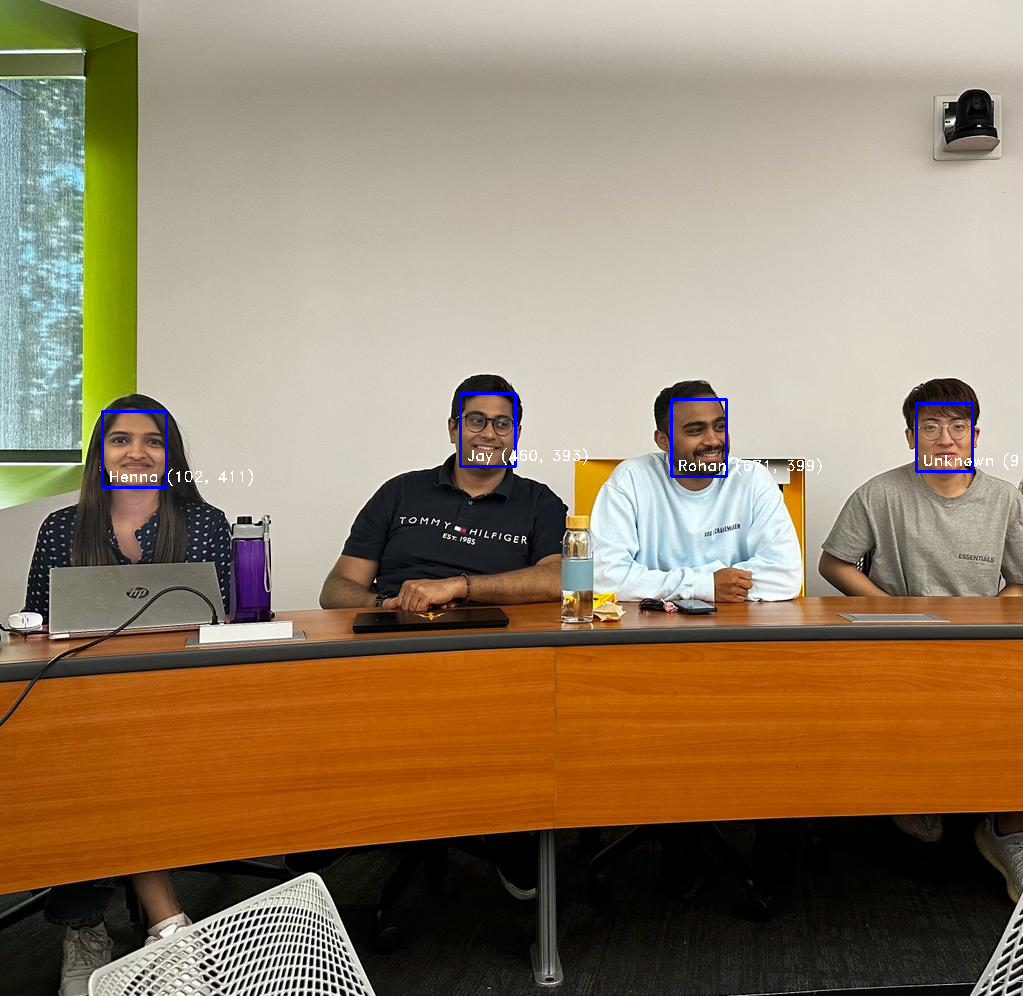

In [ ]:
from google.colab.patches import cv2_imshow
if __name__ == '__main__':

    #Test Image Path 
    image_path = "/content/drive/MyDrive/Test/Final Test.jpeg"

    recognized_names, recognized_face_locations = recognize_faces(image_path, known_faces, face_recognition_model)

    print(recognized_names)

    # Load the image again to draw the bounding boxes
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes on the image
    image_with_boxes = draw_boxes(image, recognized_names, recognized_face_locations)

    # Display the image with bounding boxes
    cv2_imshow(image_with_boxes)


First, you would use the create_known_faces_database function to generate a dictionary of known face encodings for each person in your dataset. This function takes a list of names, a list of image paths for each person, and the pre-trained face_recognition_model as inputs. For each person in the dataset, the function reads all the images for that person, detects faces using the MTCNN face detector in the detect_faces function, and generates face encodings for each face using the InceptionResNetV2 model in the encode_faces function. Finally, the face encodings for each person are averaged to obtain a single representative face encoding for that person. The resulting dictionary maps each person's name to their representative face encoding.

Next, you would use the recognize_faces function to recognize the faces in your test image. This function takes an input image, the dictionary of known face encodings generated by create_known_faces_database, the pre-trained face_recognition_model, and a tolerance value as inputs.

The recognize_faces function first loads the input image and converts it to RGB format. It then uses the MTCNN face detector in the detect_faces function to detect faces in the image and the InceptionResNetV2 model in the encode_faces function to generate face encodings for each detected face.

For each detected face, the function computes the Euclidean distance between the face encoding of the detected face and the face encodings in the dictionary of known face encodings. This is done by comparing the feature vectors obtained from the InceptionResNetV2 model for each detected face with the feature vectors in the dictionary of known faces using the Euclidean distance metric.

If the minimum distance between the detected face and the known faces is less than or equal to the given tolerance value, the face is considered to be a match for the closest known face, and the name of the closest known face is returned. If the minimum distance is greater than the given tolerance value, the face is considered to be unknown, and the function returns the string "Unknown".

The main difference between processing the known images and the test image is that the known images are used to create a dictionary of known face encodings using the create_known_faces_database function, while the test image is processed using the recognize_faces function to recognize the faces in the image using the dictionary of known face encodings.


In summary, the MTCNN model is used to detect the location and size of faces in an input image, while the InceptionResNetV2 model is used to extract a feature vector that represents the face encoding for each detected face. Together, these two models enable face recognition by comparing the feature vectors of detected faces with a database of known face encodings.




The InceptionResNetV2 model used in this code is a deep convolutional neural network architecture that was proposed by Google researchers in 2016. It was designed to be an improvement over previous Inception models, which are known for their efficient use of computation resources.

The InceptionResNetV2 model consists of 164 layers and has over 55 million parameters. It is trained on a large dataset of images called ImageNet, which contains over a million images with 1000 categories. The model is pre-trained on this dataset using a supervised learning approach, where it learns to classify the images into their respective categories.

The InceptionResNetV2 model is a variant of the Inception architecture, which utilizes inception modules that are designed to capture features of different sizes. These inception modules consist of parallel convolutions with different filter sizes, which are concatenated together to form a single output. The InceptionResNetV2 model also incorporates residual connections, which allow the model to learn more effectively by enabling the gradient flow through the network.

During training, the InceptionResNetV2 model learns to extract features from images that are relevant for classification. These features are then used to make predictions about the class of the image. In the case of face recognition, the InceptionResNetV2 model is used to extract features from the detected faces, which are then compared to the known face encodings to recognize the faces in the input image.

Overall, the InceptionResNetV2 model is a powerful deep learning architecture that has been shown to perform well on a variety of computer vision tasks, including image classification, object detection, and face recognition.